In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import accuracy_score

from reviews_cleaner import TextProcessing
from utils import  return_top_terms, return_clustering_metrics, plot_word_clouds

#### File paths

In [3]:
DATA_PATH = 'C:\\Users\\sasha\\Desktop\\DS\Big Data Computing\\Homework 2\\corpus.txt'
TARGET_PATH = 'C:\\Users\\sasha\\Desktop\\DS\Big Data Computing\\Homework 2\\labels.txt'

#### Data import and cleaning

In [4]:
cleaner = TextProcessing(DATA_PATH, TARGET_PATH, 
                          frac_review = 15, 
                          min_word_len = 2,
                          select_nouns = False)

cleaner.import_and_clean()
text, labels = cleaner.processed_texts, cleaner.true_target

processing text: 314808it [00:47, 6688.76it/s]


#### Text vectorization

In [5]:
vectorizer = TfidfVectorizer(stop_words='english', 
                             strip_accents='unicode', 
                             min_df = 1, max_df = 0.25,
                             max_features = 20000)

X = vectorizer.fit_transform(text)
terms = vectorizer.get_feature_names()

#### First clustering: Mini batch Kmeans 



Homogeneity: 0.429
Completeness: 0.459
V-measure: 0.443
Adjusted Rand-Index: 0.446
Silhouette Coefficient: 0.005
Accuracy: 0.834


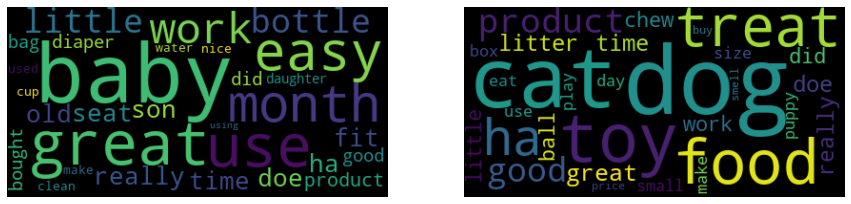

In [20]:
scaler = Normalizer()
bkm = MiniBatchKMeans(n_clusters = 2, init='k-means++', 
                      batch_size=1000, max_iter=100,
                     )
bkm.fit(scaler.fit_transform(X)) # normalization of the data

top_terms_bkm = return_top_terms(bkm.cluster_centers_, 
                                 terms, top_k = 30, 
                                 return_list=True)
return_clustering_metrics(bkm.labels_, labels, X)
plot_word_clouds(top_terms_bkm)

#### Dimensionality reduction

In [40]:
svd = TruncatedSVD(2)
scaler = Normalizer()
lsa = make_pipeline(svd, scaler) # scaler is defined above
Y = lsa.fit_transform(X)
sum(svd.explained_variance_ratio_) # total explained variance of the SVD components

0.010599538829052851

#### Second clustering: Kmeans after SVD



Homogeneity: 0.450
Completeness: 0.472
V-measure: 0.461
Adjusted Rand-Index: 0.490
Silhouette Coefficient: 0.680
Accuracy: 0.850


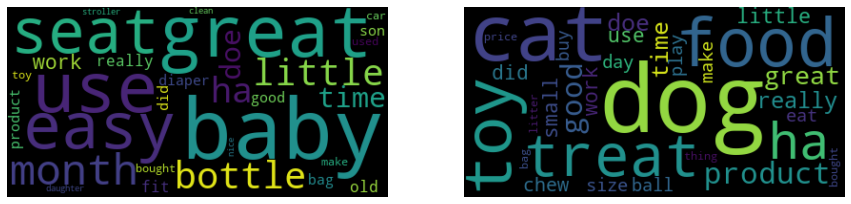

In [41]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100,
           )
km.fit(Y)

original_centroids = svd.inverse_transform(km.cluster_centers_) # go back to the original space

top_terms_svd_km = return_top_terms(original_centroids, 
                                    terms, top_k = 30, 
                                    return_list=True)
return_clustering_metrics(km.labels_, labels, Y)
plot_word_clouds(top_terms_svd_km)

#### Third clustering: Gaussian mixtures after SVD



Homogeneity: 0.475
Completeness: 0.486
V-measure: 0.480
Adjusted Rand-Index: 0.546
Silhouette Coefficient: 0.677
Accuracy: 0.869


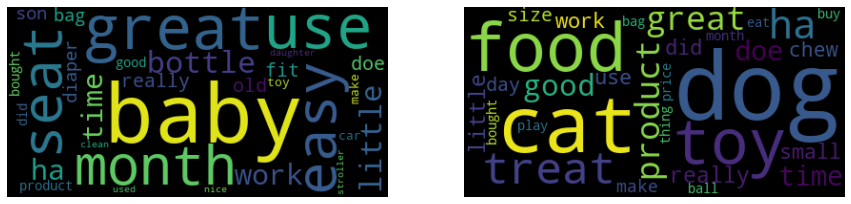

In [42]:
gm = GaussianMixture(n_components=2, random_state=2)
gm.fit(Y)

original_centroids = svd.inverse_transform(gm.means_)

top_terms_svd_gm = return_top_terms(original_centroids, 
                                    terms, top_k = 30, 
                                    return_list=True)
return_clustering_metrics(gm.predict(Y), labels, Y)
plot_word_clouds(top_terms_svd_gm)